In [1]:
import keras
keras.__version__

'2.10.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [2]:
from keras.layers import SimpleRNN

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [10]:
FLAG = True
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=FLAG))
model.add(SimpleRNN(32, return_sequences=FLAG))
model.add(SimpleRNN(32, return_sequences=FLAG))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [15]:
from keras.datasets import imdb
# from keras.preprocessing import sequence
from keras_preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [16]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - ETA: 0s - loss: 0.5915 - acc: 0.6707

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


20000/20000 [==============================] - 68s 3ms/sample - loss: 0.5915 - acc: 0.6707 - val_loss: 0.4502 - val_acc: 0.7950
Epoch 2/10
20000/20000 [==============================] - 69s 3ms/sample - loss: 0.3760 - acc: 0.8416 - val_loss: 0.3977 - val_acc: 0.8272
Epoch 3/10
20000/20000 [==============================] - 71s 4ms/sample - loss: 0.2812 - acc: 0.8863 - val_loss: 0.3851 - val_acc: 0.8298
Epoch 4/10
20000/20000 [==============================] - 76s 4ms/sample - loss: 0.2166 - acc: 0.9168 - val_loss: 0.5304 - val_acc: 0.8248
Epoch 5/10
20000/20000 [==============================] - 78s 4ms/sample - loss: 0.1600 - acc: 0.9410 - val_loss: 0.6028 - val_acc: 0.8158
Epoch 6/10
20000/20000 [==============================] - 79s 4ms/sample - loss: 0.1088 - acc: 0.9629 - val_loss: 0.4164 - val_acc: 0.8598
Epoch 7/10
20000/20000 [==============================] - 79s 4ms/sample - loss: 0.0696 - acc: 0.9786 - val_loss: 0.5831 - val_acc: 0.8034
Epoch 8/10
20000/20000 [==============

Let's display the training and validation loss and accuracy:

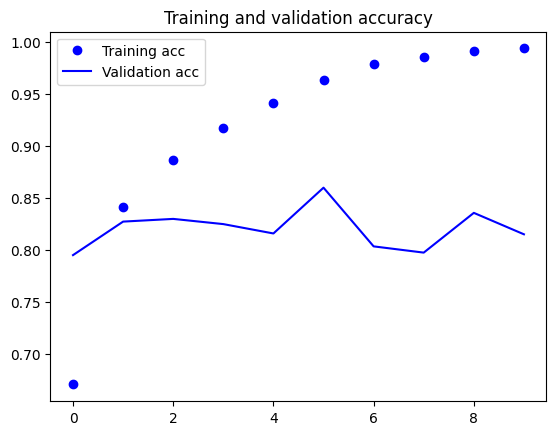

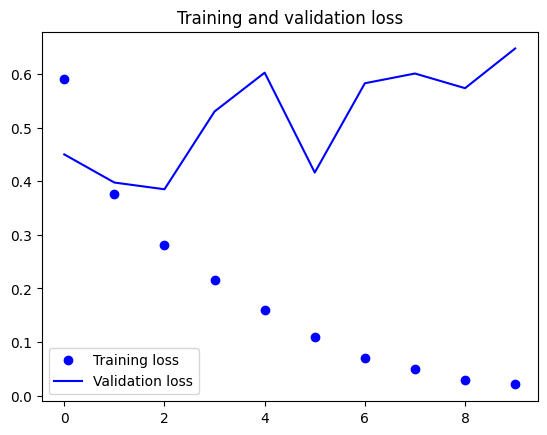

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - ETA: 0s - loss: 0.5066 - acc: 0.7639

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


20000/20000 [==============================] - 130s 6ms/sample - loss: 0.5066 - acc: 0.7639 - val_loss: 0.3750 - val_acc: 0.8600
Epoch 2/10
20000/20000 [==============================] - 141s 7ms/sample - loss: 0.2995 - acc: 0.8814 - val_loss: 0.2999 - val_acc: 0.8820
Epoch 3/10
20000/20000 [==============================] - 168s 8ms/sample - loss: 0.2351 - acc: 0.9109 - val_loss: 0.9201 - val_acc: 0.7282
Epoch 4/10
20000/20000 [==============================] - 161s 8ms/sample - loss: 0.1976 - acc: 0.9265 - val_loss: 0.3924 - val_acc: 0.8424
Epoch 5/10
20000/20000 [==============================] - 154s 8ms/sample - loss: 0.1760 - acc: 0.9358 - val_loss: 0.3239 - val_acc: 0.8820
Epoch 6/10
20000/20000 [==============================] - 152s 8ms/sample - loss: 0.1588 - acc: 0.9426 - val_loss: 0.5525 - val_acc: 0.8254
Epoch 7/10
20000/20000 [==============================] - 151s 8ms/sample - loss: 0.1469 - acc: 0.9474 - val_loss: 0.3156 - val_acc: 0.8724
Epoch 8/10
20000/20000 [=======

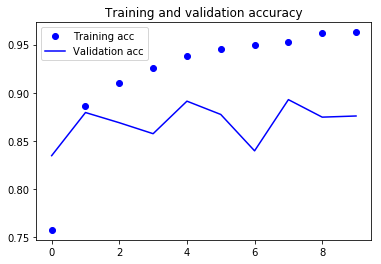

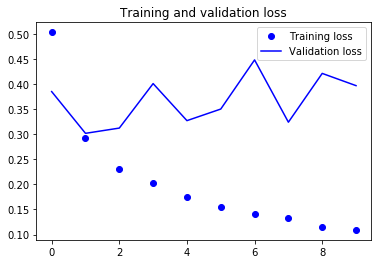

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()